# Boson Star Notebook

Here are all the libraries we will use later.

In [2]:
import numpy as np
import pylab as pl
import matplotlib
import os

from IPython import display
from datetime import datetime
from scipy.optimize import minimize, curve_fit
from matplotlib import pyplot as plt
    
from BosonStar import BosonStar 
import Ground_State_Recursive as get_Ground

ModuleNotFoundError: No module named 'BosonStar'

In [4]:
matplotlib.rcParams.update({'font.size': 13})

## 1) Define Ground State Field and Potential Functions 

Some time ago, I wrote a `BosonStar` class that calculates the wavefunction and potential profile for a boson star using the expansion. See the file `BosonStar.py` in the same directory as this notebook.  

You first initialize the `BosonStar` class for a given self interaction parameter `gamma`, and then use the function `BosonStar.get_profile(z)` to get the profile for an array of radii `z` at a specified order of the expansion. 

In [5]:
gamma=0
ground_state=BosonStar(gamma=gamma)

z=np.linspace(0,50,200)
s,v=ground_state.get_profile(z,z_match=1.3,n_near=10,n_far=4,m_far=4)

NameError: name 'BosonStar' is not defined

Let's plot the result

In [4]:
import math


def get_Ground_def(R):
    import Ground_State_Recursive as get_Ground
    with open(f'Ground_State_recursive.txt', 'w') as f:

        print  ('r', ',', 'S_1',',','V_1',file=f)
    f.close()

    s=np.empty(len(R))

    v=np.empty(len(R))
    for i in range (0,len(R)):
        R1=R[i]

        if R1<2:
            s[i],v[i]=get_Ground.phi_small(R1,0,100)
    
            with open(f'Ground_State_recursive.txt', 'a') as f:
           # f.write('r,S,ds,V,dv,dm')
                print  (R1, ',', s[i],',',v[i],file=f)
            f.close()
        else:
            s[i],v[i]=get_Ground.phi_large(R1,0,4,4)
            with open(f'Ground_State_recursive.txt', 'a') as f:
           # f.write('r,S,ds,V,dv,dm')
                print  (R1, ',', s[i],',',v[i],file=f)
            f.close()
        
    return()
    
    


get_Ground_def(z)

In [5]:
R2,S_0,V_0=np.loadtxt(f'Ground_State_recursive.txt', delimiter=',', skiprows=1,unpack=True )

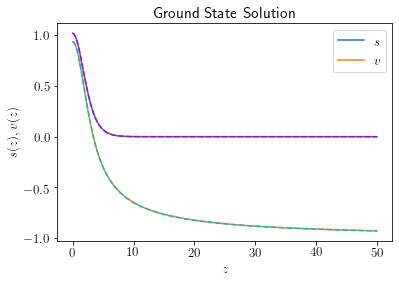

In [6]:




f=plt.figure() 
plt.plot(z,s,label=r"$s$")
plt.plot(z,v,label=r"$v$")
plt.plot(R2,S_0,'m--')
plt.plot(R2,V_0,'c--')
plt.xlabel(r'$z$')
plt.ylabel(r'$ s(z),  v(z)$')
plt.title('Ground State Solution')
plt.legend()
plt.show()

## 2) Numerical Solution for Pertubation in Two-State Ansatz 

We now want to obtain a perturbed solution $s(z)=s_0(z) + \epsilon s_1(z)$ and $v(z)=v_0(z) + \epsilon  v_1(z)$, where the perturbation is specified by angular quantum numbers $\ell$ and $m$. The corresponding differential equations we need to solve are

\begin{equation}
 \nabla^2 s_1 = - v_0 s_1 + 3 \gamma s_0^2 s_1 + \Gamma  s_1 \quad  
\end{equation}

When solving these equation we choose the following boundary conditions for the perturbed solution: $s_1|_{z=0}=0$, $v_1|_{z=0}=0$, $\partial_z s_1|_{z=0}=s_{11}$ and  $\partial_z v_1|_{z=0}=1$. In the last condition we used our freedom to normalize both $s_0$ and $v_0$, and set the slope of $v_1$ at the origin to be unity. The perturbed solution is therefore described by a single parameter: $\partial_z s_1|_{z=0}=s_{11}$. 

Let us first rewrite the differential equations a bit using $\nabla^2 s_1 = s_1'' + 2/z \times s_1'  - \ell(\ell+1)/z^2 \times s_1$. Now we can write

\begin{equation}
\begin{aligned}
ds_1/dz &= f_{s}(z,s_1,s_1',v_1,v_1')= s_1 ' \\
ds_1'/dz&= f_{ds}(z,s_1,s_1',v_1,v_1')= -2/z \times s_1' + \ell(\ell+1)/z^2 \times s_1  - v_0 s_1 - 3 \gamma s_0^2 s_1 + \Gamma s_1 \\
\end{aligned}
\end{equation}

Let us now code up these differential equations:

In [7]:
def func_s(z,s1,s1p,l,gamma,ggamma):
    return s1p

def func_ds(z,s1,s1p,l,gamma,ggamma):
    profile = ground_state.get_profile([z])
    s0, v0 = profile[0][0], profile[1][0]
    return -2./z*s1p + (l*(l+1)/z**2)*s1 - v0*s1 + ggamma*s1 #+ 3.*gamma*s0**2*s1 



In [8]:
def rungekutta_step(z, s1, ds1, h, l, gamma, ggamma): 
    
  #  print(ds1)
    k1_s  = func_s (z, s1, ds1, l, gamma, ggamma)
    k1_ds = func_ds(z, s1, ds1, l, gamma, ggamma)

    
    
    
  #  print(z,k1_ds)
        
    k2_s  = func_s (z+h/2, s1+h/2*k1_s, ds1+h/2*k1_ds, l, gamma, ggamma)
    k2_ds = func_ds(z+h/2, s1+h/2*k1_s, ds1+h/2*k1_ds, l, gamma, ggamma)

      
   # print(z,k2_ds)
    
    k3_s  = func_s (z+h/2, s1+h/2*k2_s, ds1+h/2*k2_ds, l, gamma, ggamma)
    k3_ds = func_ds(z+h/2, s1+h/2*k2_s, ds1+h/2*k2_ds, l, gamma, ggamma)

        
   # print(k3_s)
        
    k4_s  = func_s (z+h, s1+h*k3_s, ds1+h*k3_ds, l, gamma, ggamma)
    k4_ds = func_ds(z+h, s1+h*k3_s, ds1+h*k3_ds, l, gamma, ggamma)

    #print(z,k1_ds,k2_ds,k3_ds,k4_ds)    
        
    ksum_s  = k1_s + 2*k2_s + 2*k3_s + k4_s
    ksum_ds = k1_ds+ 2*k2_ds+ 2*k3_ds+ k4_ds

        
    step_s  = h/6.*ksum_s
    step_ds = h/6.*ksum_ds

    
    return step_s, step_ds

Now we can write a function for the integration algorithm: `onestatesolution(l,gamma,ggamma,s11)` which numerically calculates the perturbed profile for fixed values $\ell$, $\gamma$, $\Gamma$ and $s_{11}$. 

In [9]:
def twostatesolution(l,gamma,ggamma,do_write=False):
   
    #step size 
    h=.01 
    
    #initial consitions
    z=h/2.
    dS_1 = 1
   
    S_1 = dS_1*z
   # i=0
    
    #prepare output
    output_z, output_S1, output_dS1 = [], [], []
    
    if do_write:
        with open(f'Type Solutions{ggamma+1} l={l}.csv', 'w') as f:
            print  ('r', ',','\t', 'S',',','\t','dS',',','\t','V',',','\t','dV',file=f)
        f.close()
  
    #Condition to ensure I see full behaivior up to when the functions starts diverging.
    while(abs(S_1)<3) :
#    while(z<20) :
        
        if do_write:
            with open(f'Type Solutions{ggamma+1} l={l}.csv', 'a') as f:
                print  (z, ',','\t', S_1,',','\t',dS_1,',','\t',V_1,',','\t',dV_1,file=f)
            f.close()

        output_z.append(z)
        output_S1.append(S_1)
        output_dS1.append(dS_1)

 
        step_s, step_ds= rungekutta_step(z, S_1, dS_1, h, l, gamma, ggamma)
        z    = z    + h
        S_1  = S_1  + step_s

        dS_1 = dS_1 + step_ds

        #i=i+1
    return np.array(output_z),np.array(output_S1),np.array(output_dS1)

mu=-0.8895302851470911
z1,s1,b_new=twostatesolution(l=1,gamma=0,ggamma=mu,do_write=False)
np.save("profile_3.npy",[z1, s1])

plt.plot(r,S)

Now, let's plot one solution for $\gamma=0$.

## 3) Find Physical Solution

We know that at large radii $z\gg1$, both the potential and the field should approach zero. However, for most values of $s_{11}$ and $\Gamma$, the solution will diverge as $s \sim e^z$ and $v \sim z$. We therefore search for a solution for which $|log s(z_{far})|$ and $|v(z_{far})|$ are minimized for some large value $z_{far} \gg 1$. 

So let us define $s_(z|s_{11},\Gamma)$ and $v(z|s_{11},\Gamma)$ as the numerical solutions for the profile corresponding to $s_{11}$ and $\Gamma$. We define a loss function 

\begin{equation}
L(\mu,\Gamma) = log |s(z_{far}|s_{11},\Gamma)| +  |v(z_{far}|s_{11},\Gamma)|
\end{equation}

In [10]:
def func_vfar(x, a, b):
    return a * np.exp(b*x)

result_array=[]
def lossfunction(x):

    #get solution for l=1 and gamma=0
    z1,s1,_=twostatesolution(l=1,gamma=0,ggamma=x,do_write=False)
   # print(z1)
   # s0,v0 = ground_state.get_profile(z1)
    
    #get loss function
    ipos=10
    #while ipos<len(s1) and abs(s1[ipos])>0.001: ipos+=1
    imin=int(0.3*len(z1))#min(int(0.7*len(z1)), ipos)
    while ipos<len(s1) and abs(s1[ipos])<0.1: ipos+=1
    imax=int(0.5*len(z1))
    #imax=min(len(z1)-1, max(ipos,int(0.75*len(z1))))
    params,pcov = curve_fit(func_vfar, z1[imin:imax], s1[imin:imax])
    
    error=[]
    for i in range(len(params)):
        try:
          error.append(np.absolute(pcov[i][i])**0.5)
        except:
          error.append( 0.00 )
    pfit_curvefit = params
    perr_curvefit = np.array(error)
    
    #define loss function
   # loss=sum(abs(z1*s1))[0]
    #print(loss)
    #loss=100-z1[-1]
    loss = z1[-1]*(-1 + 5*abs(params[0]) ) 
    #loss=-0.88095302851470911 - x[0]
    #print(z1[-1])
    #plot 
    lims=[-1.2,1.5]
    fig = plt.figure(figsize=(10,8))
    
    lims=[-1.2,1.5]
    ax1 = plt.subplot(2,1,1)
    #ax1.plot(z0,s0,label=r"$s_0$")
    #ax1.plot(z0,v0,label=r"$v_0$")
    ax1.plot(z1,s1,label=r"$s_1$")
    #ax1.plot(z1,v1,label=r"$v_1$")
    ax1.plot(z1[imin:imax], func_vfar(z1[imin:imax], *params),  ls="dashed", c="k") 
    ax1.set_xlabel(r'$z$')
    ax1.set_ylabel(r'$ s(z),v(z)$')
    ax1.text(0,lims[0]+0.36*(lims[1]-lims[0]),r"ipos="+str(imin)+"/"+str(imax))
    ax1.text(0,lims[0]+0.29*(lims[1]-lims[0]),r"v-slope="+str(round(params[0],10)))
    ax1.text(0,lims[0]+0.22*(lims[1]-lims[0]),r"$s_{11}$="+str(round(x[0],10)))
    #ax1.text(0,lims[0]+0.15*(lims[1]-lims[0]),r"$\Gamma$="+str(round(x[1],10)))
    ax1.text(0,lims[0]+0.08*(lims[1]-lims[0]),r"loss="+str(round(loss,5)))
    ax1.legend(loc="upper right",frameon=False)
    ax1.set_ylim(lims[0],lims[1])
    ax1.grid(True)
    
    ax2 = plt.subplot(2,1,2)
    #ax2.plot(z0,s0,label=r"$s_0$")
    #ax2.plot(z0,v0,label=r"$v_0$")
    ax2.plot(z1,s1,label=r"$s_1$")
   # ax2.plot(z1,v1,label=r"$v_1$")
    ax2.plot(z1[imin:imax], func_vfar(z1[imin:imax], *params),  ls="dashed", c="k") 
    ax2.set_yscale('log')
    ax2.set_xlabel(r'$z$')
    ax2.set_ylabel(r'$ s(z),v(z)$')
    ax2.legend(loc="upper right",frameon=False)
    ax2.set_ylim(lims[0],lims[1])
    ax2.grid(True)
    
    
    display.clear_output(wait=True)
    display.display(pl.gcf())   
    plt.close()
    
    
    #print output
    nowtime = datetime.now()
    with open("result3.txt", "a") as myfile:
        myfile.write(str(x[0])+
            " "+str(s1[-1])+" "+str(params[0])+" "+str(loss)+
            " "+str( (nowtime-starttime).total_seconds())+"\n") 
        
    np.save("profile_3.npy",[z1, s1])
   # print(perr_curvefit)
    return loss

In [11]:
from scipy.optimize import Bounds

and use `scipy.optimize.minimize` to minimize it. 

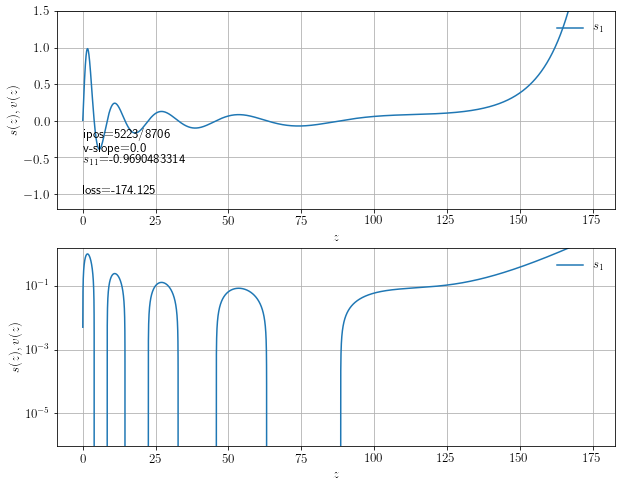

KeyboardInterrupt: 

In [12]:
if os.path.exists("result3.txt"):os.remove("result3.txt")
starttime = datetime.now()
#bnd= Bounds([-.9], [-.85])
minimize(lossfunction, x0=-0.88095302851470911 ,bounds=[(-.9,-.85)],method='Nelder-Mead', tol=1e-6,
    options={'xatol': 0.0001, 'disp': True} )

# whittaker gives   $v^{1}_{02}=10.77060048 $  and $s^{1}_{10}=10.2113878 $ 

# Near Fits gives: $v^{1}_{1}=1$  and $s^{1}_{1}=0.91828328  $